# Café com Analytics: Problema de classificação

Juntamente com Adachi, vamos explorar o [dataset do Titanic](https://www.kaggle.com/c/titanic), Ao longo desse desenvolvimento, usaremos as seguintes metodologias para o trabalho em equipe:
1. [Git flow](https://guides.github.com/introduction/flow/); e
1. [CRISP-ML(Q)](https://arxiv.org/abs/2003.05155).

## Formato deste notebook:

Logo no final desta célula, estará a conclusão deste notebook e a conclusão estará datada, pois ela é mutável de acordo com o andamento da análise e criação do modelo.

## Conclusão

### 16/01/21

---

# Business and data undertanding

O problema proposto é ***“what sorts of people were more likely to survive?”***. Ou seja, trataremos de um problema de classificação binária (sobreviveu ou não) e nosso modelo tem também a missão de fazer inferências sobre a influência dos atributos preditores sobre a resposta.

In [1]:
import os

import pandas as pd
import numpy as np
from feature_engine import categorical_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

os.chdir("../src/")
from utils.data_describe import DataDescribe as dd

raw_path = "../data/raw/"
external_path = "../data/external/"
interim_path = "../data/interim/"
reports_path = "../reports/"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# load the autoreload extension
%load_ext autoreload

# Set extension to reload modules every time before executing code
%autoreload 2

In [2]:
# List all files in a directory using scandir()
with os.scandir(raw_path) as entries:
    for entry in entries:
        if entry.is_file():
            print(entry.name)

.gitkeep
train.csv
test.csv
gender_submission.csv


## Explorando dados

In [3]:
df_train = pd.read_csv(raw_path+'train.csv', index_col="PassengerId")
df_test = pd.read_csv(raw_path+'test.csv', index_col="PassengerId")

print(f"""O dataframe df_train possui:
- {df_train.shape[0]} registros; e
- {df_train.shape[1]} atributos, incluindo a variável resposta ("Survived").
""")

print(f"""O dataframe df_test possui:
- {df_test.shape[0]} registros; e
- {df_test.shape[1]} atributos, SEM a variável resposta ("Survived").
""")

df_train.head()

O dataframe df_train possui:
- 891 registros; e
- 11 atributos, incluindo a variável resposta ("Survived").

O dataframe df_test possui:
- 418 registros; e
- 10 atributos, SEM a variável resposta ("Survived").



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dd.serie_nulos(df_train, corte=0.001)

3 atributos/features/campos possuem mais de 0.001 de valores nulos.


Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
df_train_eda = df_train.drop(['Ticket', 'Name'], axis=1)

profile = ProfileReport(df_train_eda, title="Relatório de Estatística Descritiva", explorative=True)

# profile.to_notebook_iframe();

# plotando com widgets
profile.to_widgets()

# É possível exportar o relatório de análise estatística descritiva para um HTML.
profile.to_file(reports_path+"relatorio_estatistica_descritiva.html")

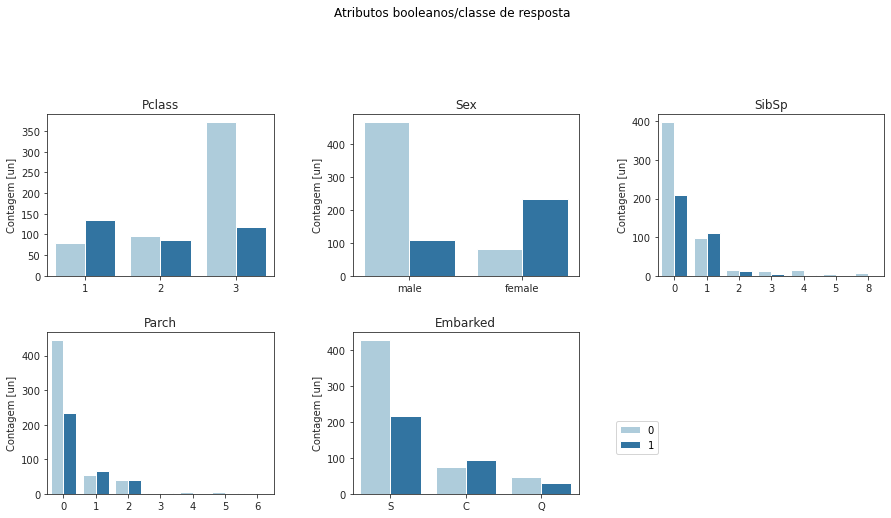

In [44]:
lst_cat = list(df_train_eda.select_dtypes(include=['object','int','int32','int64']).columns)
lst_cat.remove('Cabin')
lst_cat.remove('Survived')

f = plt.figure(figsize=(15, 15))
f.suptitle('Atributos booleanos/classe de resposta')
sns.set_palette("Paired")
# w = h = 1
# widths = [w,w,w,w]
# heights = [h,h,h,h]
gs = f.add_gridspec(nrows=4, ncols=3, wspace=.35, hspace=.35
#                     width_ratios=widths, height_ratios=heights
                   );

row = col = 0
for i, feature in enumerate(lst_cat):
    with sns.axes_style("ticks"):
        ax = f.add_subplot(gs[row, col])
        ax = sns.countplot(x=feature, hue='Survived', data=df_train_eda)
        ax.set(title=feature, xlabel='', ylabel='Contagem [un]')
        ax.get_legend().set_visible(False)
        if (i+1)%3!=0:
            col += 1
        else:
            col = 0
            row+=1

plt.legend(bbox_to_anchor=(1.35, 0.45),borderaxespad=0);

# textstr = f"""Usaremos como primeira abordagem
# somente {len(lst_X_train_booleanas)} atributos booleanos,
# pois os outros {len(lst_booleanos)-len(lst_X_train_booleanas)} atributos booleanos
# têm menos de {remover_proporcao}% de classe minoritária."""

# props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)

# ax.text(1.5, 0.975, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=props);

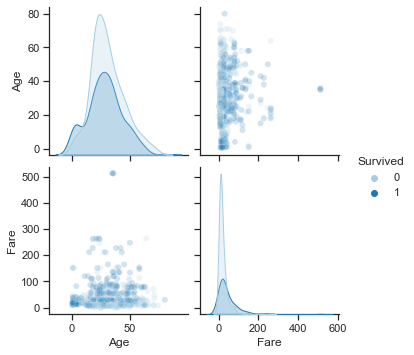

In [54]:
lst_cont = ['Survived', 'Age', 'Fare']

sns.set(style="ticks")
sns.set_palette("Paired")

ax = sns.pairplot(df_train_eda[lst_cont], hue="Survived", plot_kws={'alpha':0.2})

Logo acima, podemos ver que temos alguns valores nulos *("NaN")* nos atributos *Cabin* , *Age* e *Embarked*. Nessa primeira interação, vamos substituir da seguinte maneira:
- Se o atributo for categórico e não numérico, colocaremos "não informado";
- Se o atributo for numérico, trocaremos pela mediana.